## Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models
import torch.nn as nn
from torchvision.transforms import v2

In [2]:
import spoofdet.config as config
from spoofdet.model_utils import get_transform_pipeline, evaluate_model, train_model, checkImage, checkAugmentedImage, create_subset, checkDatasetDistribution, display_train_result, save_results, analyze_spoof_types, analyze_dataset_spoof_distribution
from spoofdet.dataset import CelebASpoofDataset

## randomizer

In [3]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

## Model


In [4]:
from ultralytics import YOLO

yolo_model = YOLO('yolov8n-cls.pt')

# unfreeze
model = yolo_model.model
for param in model.parameters():
    param.requires_grad = True

# Adjust the final layer for 2 classes (Live/Spoof)
classify_head = model.model[-1]

num_features = classify_head.linear.in_features
classify_head.linear = nn.Sequential(
    nn.Linear(num_features, 128),
    nn.BatchNorm1d(128),  
    nn.ReLU(),
    nn.Dropout(0.2),    
    nn.Linear(128, 2)
)

## preparation


In [5]:
import multiprocessing
from torch.utils.data import Subset


PROFILER_NAME = "yolov8n-cls"
BATCH_SIZE= 32


EPOCHS = config.EPOCHS
EARLY_STOPPING_LIMIT = config.EARLY_STOPPING_LIMIT
TARGET_SIZE = 640
#TARGET_SIZE = config.TARGET_SIZE
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-2

WORKERS = 4

SPOOF_PERCENT = 0.5
TRAIN_IMG_COUNT = 10000
VAL_IMG_COUNT = int(TRAIN_IMG_COUNT * 0.1)  
TEST_IMG_COUNT = int(TRAIN_IMG_COUNT * 0.1)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
bbox_lookup = "../bbox_lookup.json"

num_cpus = multiprocessing.cpu_count()

class_weights = torch.tensor([1.0, 1.2]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

device

device(type='cuda')

In [6]:
# Add this cell before the training cell

class ModelWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    
    def forward(self, x):
        output = self.model(x)
        # YOLOv8 returns tuple, extract logits
        if isinstance(output, tuple):
            return output[0]
        return output

# Wrap the model
model = ModelWrapper(model)
model.to(device)

ModelWrapper(
  (model): ClassificationModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_

In [7]:
gpu_transforms_train, gpu_transforms_val = get_transform_pipeline(device=device, target_size=TARGET_SIZE)

In [8]:


all_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TRAIN_JSON,
    bbox_json_path=bbox_lookup,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

test_ds = CelebASpoofDataset(
    root_dir=config.ROOT_DIR,
    json_label_path=config.TEST_JSON,
    bbox_json_path=bbox_lookup,
    target_size = TARGET_SIZE,
    bbox_original_size = config.BBOX_ORGINAL_SIZE
)

# Create random indices for train/val split without overlap
indices = torch.randperm(len(all_ds)).tolist()
split_idx = int(0.5 * len(all_ds))

train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

train_ds = Subset(all_ds, train_indices)
val_ds = Subset(all_ds, val_indices)


Loading BBox Cache into RAM...
Loading BBox Cache into RAM...


In [9]:
len(train_ds)

247202

In [10]:

np.random.seed(seed)

small_train_ds = create_subset(train_ds, total_size=TRAIN_IMG_COUNT, spoof_percent=SPOOF_PERCENT)
small_val_ds = create_subset(val_ds, total_size=VAL_IMG_COUNT, spoof_percent=SPOOF_PERCENT)
small_test_ds = create_subset(test_ds, total_size=TEST_IMG_COUNT)
print(f"Created Balanced Train: {len(small_train_ds)} images")

 Scanning specific indices for class balance...
 Found in this split: 80886 Live | 166316 Spoof
 Scanning specific indices for class balance...
 Found in this split: 81576 Live | 165627 Spoof
 Scanning specific indices for class balance...
 Found in this split: 19923 Live | 47247 Spoof
Created Balanced Train: 10000 images


In [11]:
len(small_train_ds)

10000

In [12]:
len(small_val_ds)

1000

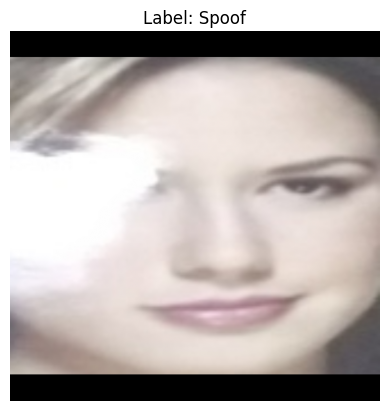

In [13]:

# 1 = spoof  0 = live 
checkImage(small_train_ds, 210)

In [14]:
# # check distribution of live and spoof in small_test_ds
# checkDatasetDistribution(small_test_ds)

In [15]:
# checkDatasetDistribution(small_train_ds)

In [16]:
# checkDatasetDistribution(small_val_ds)

## Data Loader

In [17]:
from torch.utils.data import DataLoader
small_train_loader = DataLoader(small_train_ds, 
                                batch_size=BATCH_SIZE, 
                                shuffle=True,
                                num_workers=2,
                                pin_memory=True,
                                persistent_workers=True
          
                   
)
small_val_loader = DataLoader(small_val_ds, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=2,
                              pin_memory=True,
                              persistent_workers=True
                
                    
)
small_test_loader = DataLoader(small_test_ds, 
                               batch_size=BATCH_SIZE, 
                               shuffle=False,
                                num_workers=2,
                                pin_memory=True,
                                persistent_workers=True
                                )

In [18]:
# def verify_weights(dataset):
#     # 1. Grab a sample you KNOW is Live
#     # (You might need to check your folders/JSON to find a specific filename or index)
#     # For now, let's just check the first item and print what it is.
#     img, label = dataset[0] 
    
#     print(f"Sample Index 0 has Label: {label}")
    
#     # Logic check:
#     # If your JSON says 0 = Live and 1 = Spoof
#     if label == 0:
#         print("Class 0 appears to be Live.")
#     elif label == 1:
#         print("Class 1 appears to be Spoof.")
        
#     print("-" * 30)
    
#     # 2. Define Weights
#     # If 0 is Live, we want the FIRST weight to be small (1.0)
#     # If 1 is Spoof, we want the SECOND weight to be large (3.0)
#     print("Recommended Weights based on standard (0=Live, 1=Spoof):")
#     print("torch.tensor([1.0, 3.0])") 
#     print(" -> Index 0 (Live) gets weight 1.0")
#     print(" -> Index 1 (Spoof) gets weight 3.0 (Focus here!)")

# verify_weights(small_train_ds)

In [19]:
sample_img, sample_label = small_train_ds[0]
sample_img.shape, sample_label

(torch.Size([3, 640, 640]), tensor(0))

In [20]:
# Add a test cell after the ModelWrapper to verify it works

def test_model_wrapper(model, small_train_ds, device):
    model.eval()
    print("Testing ModelWrapper...")
    test_img, _ = small_train_ds[0]
    test_img = test_img.unsqueeze(0).to(device)
    test_img = test_img.float() / 255.0
    output = model(test_img)
    print(f"Output type: {type(output)}")
    print(f"Output shape: {output.shape if isinstance(output, torch.Tensor) else 'Not a tensor!'}")
    print(f"Is tensor: {isinstance(output, torch.Tensor)}")

test_model_wrapper(model, small_train_ds, device)

Testing ModelWrapper...
Output type: <class 'torch.Tensor'>
Output shape: torch.Size([1, 2])
Is tensor: True


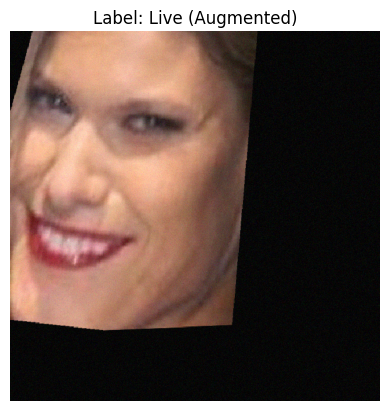

In [21]:
checkAugmentedImage(small_train_ds, 2, gpu_transforms=gpu_transforms_train)

## Train

In [22]:
model, history = train_model(model=model, 
                             device=device, 
                             train_loader=small_train_loader, 
                             val_loader=small_val_loader,      
                             criterion=criterion, 
                             optimizer=optimizer, 
                             epochs=EPOCHS, 
                             early_stopping_limit=EARLY_STOPPING_LIMIT,
                             train_transforms=gpu_transforms_train,
                             val_transforms=gpu_transforms_val,
                             profiler_log_name=PROFILER_NAME,
                             scheduler=scheduler
                             )

Epoch [1/200] | Time: 1m 23s Train Loss: 0.4792 | Val Loss: 0.7412 | Val Precision: 50.35% | Val Accuracy: 50.70% | Val Recall: 99.80% | Val F1: 66.93%
Scheduler Step! New LR: 0.00099994  -> New best model saved!
Epoch [2/200] | Time: 0m 56s Train Loss: 0.4355 | Val Loss: 0.6868 | Val Precision: 53.44% | Val Accuracy: 55.60% | Val Recall: 87.00% | Val F1: 66.21%
Scheduler Step! New LR: 0.00099975  -> New best model saved!
Epoch [3/200] | Time: 0m 56s Train Loss: 0.4138 | Val Loss: 0.7053 | Val Precision: 61.17% | Val Accuracy: 56.90% | Val Recall: 37.80% | Val F1: 46.72%
Scheduler Step! New LR: 0.00099945  -> No improvement. Counter: 1/30
Epoch [4/200] | Time: 0m 57s Train Loss: 0.4110 | Val Loss: 0.6381 | Val Precision: 68.39% | Val Accuracy: 67.10% | Val Recall: 63.60% | Val F1: 65.91%
Scheduler Step! New LR: 0.00099901  -> New best model saved!
Epoch [5/200] | Time: 0m 57s Train Loss: 0.4182 | Val Loss: 0.6596 | Val Precision: 57.28% | Val Accuracy: 61.00% | Val Recall: 86.60% | Val

KeyboardInterrupt: 

D:\JoshFile\Github\spoofing-recognition\src\spoofdet\model_utils.py:407: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_loss.show()
D:\JoshFile\Github\spoofing-recognition\src\spoofdet\model_utils.py:417: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_precision.show()


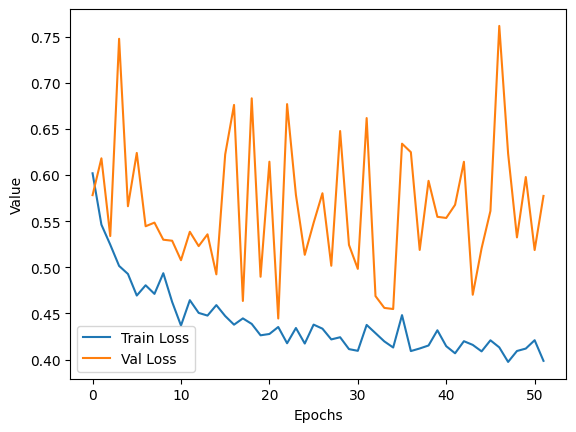

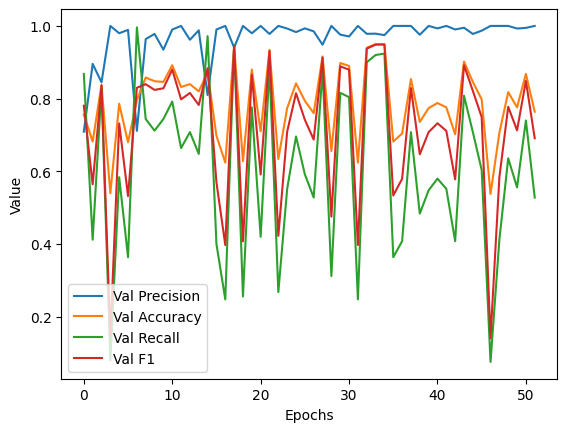

In [ ]:




train_loss_fig, precision_fig = display_train_result(history)

## test


Confusion Matrix:
         Predicted Live | Predicted Spoof
Live           242     |          8
Spoof           73     |        177


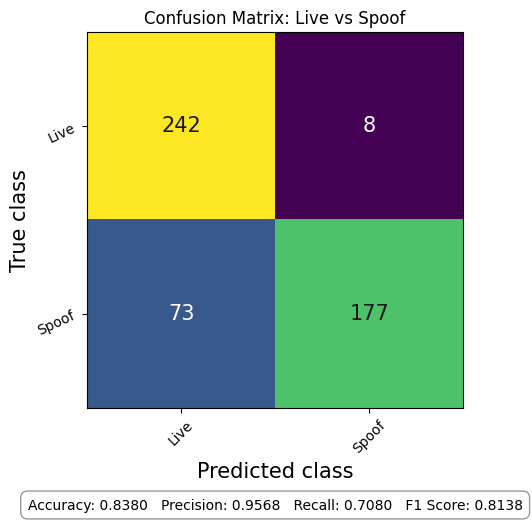

Accuracy: 0.8380
Precision: 0.9568
Recall:    0.7080
F1 Score:  0.8138


In [ ]:
confusion_matrix, accuracy, precision, recall, f1 = evaluate_model(model=model, dataloader=small_test_loader, device=device, val_transforms=gpu_transforms_val)

In [ ]:


save_results(model=model, confusion_matrix_fig=confusion_matrix, train_loss_fig=train_loss_fig, precision_fig=precision_fig)

Saving results to: train_results\train_5


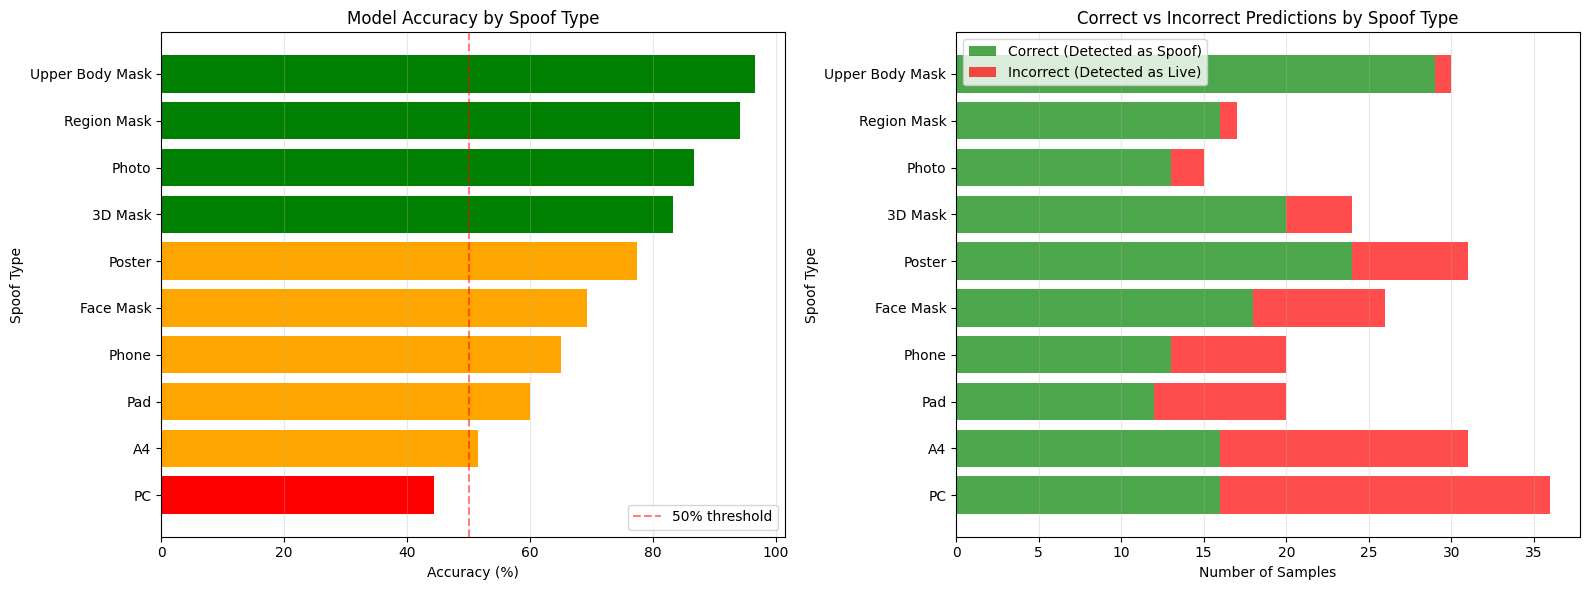


Spoof Type Analysis Results:
     Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
             PC        7     36       16         20     44.444444
             A4        3     31       16         15     51.612903
            Pad        8     20       12          8     60.000000
          Phone        9     20       13          7     65.000000
      Face Mask        4     26       18          8     69.230769
         Poster        2     31       24          7     77.419355
        3D Mask       10     24       20          4     83.333333
          Photo        1     15       13          2     86.666667
    Region Mask        6     17       16          1     94.117647
Upper Body Mask        5     30       29          1     96.666667


Worst Performing Spoof Types (Accuracy < 70%):
Spoof Type  Type ID  Total  Correct  Incorrect  Accuracy (%)
        PC        7     36       16         20     44.444444
        A4        3     31       16         15     51.612903
       Pad  

In [ ]:


# Run the analysis
spoof_analysis_df, spoof_fig = analyze_spoof_types(
    model=model,
    dataset=small_test_ds,
    device=device,
    val_transforms=gpu_transforms_val
)

In [ ]:
# Check a few samples
for i in range(5):
    _, label = small_test_ds[i]
    print(f"Sample {i}: Label = {label.item()} ({'Live' if label.item() == 0 else 'Spoof'})")

Sample 0: Label = 1 (Spoof)
Sample 1: Label = 0 (Live)
Sample 2: Label = 0 (Live)
Sample 3: Label = 1 (Spoof)
Sample 4: Label = 0 (Live)


In [ ]:
# Test with a known Live sample
img, label = small_test_ds[2]  # Adjust index to find a Live sample
print(f"True label: {'Live' if label == 0 else 'Spoof'}")

img = img.unsqueeze(0).to(device)
img = gpu_transforms_val(img)
output = model(img)
pred = torch.argmax(output, dim=1).item()
print(f"Predicted: {'Live' if pred == 0 else 'Spoof'}")

True label: Live
Predicted: Live


In [ ]:


# Analyze training dataset distribution
train_dist_df, train_dist_fig = analyze_dataset_spoof_distribution(small_train_ds)

Analyzing spoof type distribution...


AttributeError: 'Subset' object has no attribute 'image_keys'